# **Description Notebook**

**MSc in Big Data & Analytics Kosmas Katsioulas | Part B Yolo Model**

# **Libraries & Packages**

In [ ]:
!pip -q install --no-input --no-cache-dir ultralytics==8.3.180 opencv-python-headless==4.10.0.84 pandas==2.2.2 matplotlib==3.8.4 seaborn==0.13.2 pyyaml==6.0.2 tqdm==4.67 pillow==10.4.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 137.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 261.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 284.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 108.3 MB/s eta 0:00:00


In [ ]:
import os, glob, re, json, time, math, random, shutil, yaml
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import colorsys
from pathlib import Path
from zipfile import ZipFile
from collections import defaultdict, deque
from tqdm import tqdm
from ultralytics import YOLO
from IPython.display import Video, display, HTML

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)

In [ ]:
sns.set(style="whitegrid", font_scale=1.0)
plt.rcParams["figure.figsize"] = (7,4)
plt.rcParams["savefig.dpi"] = 150

# **Mount Google Drive**

In [ ]:
IN_COLAB = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except Exception:
    pass

Mounted at /content/drive


# **Useful Paths**

In [ ]:
zip_path = '/content/drive/MyDrive/Diploma/UNIRI_HBD_Dataset/uniri-hbd.zip'
extract_to = '/content/uniri-hbd'

In [ ]:
if os.path.exists(zip_path) and not os.path.exists(extract_to):

    with ZipFile(zip_path, 'r') as z:

        z.extractall(extract_to)

    print("Dataset extracted ->", extract_to)

else:

    print("Zip not used or dataset already extracted.")

Dataset extracted -> /content/uniri-hbd


In [ ]:
base_dir = os.path.join(extract_to, "handball_s")
scenes_dir = os.path.join(base_dir, "scenes")
detections_dir = os.path.join(base_dir, "player_detections")

In [ ]:
yolo_data = "/content/handball_data"
os.makedirs(yolo_data, exist_ok=True)

In [ ]:
vis_dir = "/content/vis_preds"
os.makedirs(vis_dir, exist_ok=True)

# **Useful Functions**

**Robust CSV Parser**

In [ ]:
def parse_uniri_csv(csv_path: str) -> pd.DataFrame:

    rows, cur_frame = [], None

    with open(csv_path, "r") as f:

        for raw in f:

            line = raw.strip()

            if not line:

                continue

            if line.lower().startswith("frame"):

                nums = re.findall(r"\d+", line)
                cur_frame = int(nums[0]) if nums else None
                continue

            parts = re.split(r"[,\s]+", line.strip(", "))

            if cur_frame is None or len(parts) < 5:
                continue

            try:
                x1, y1, x2, y2, conf = map(float, parts[:5])
                rows.append([cur_frame, x1, y1, x2, y2, conf])
            except Exception:
                pass

    df = pd.DataFrame(rows, columns=["frame","x1","y1","x2","y2","conf"])
    return df.sort_values("frame").reset_index(drop=True)

**Map a CSV file to its scene mp4**

In [ ]:
def csv_to_video_path(csv_path: str) -> str:

    action = os.path.basename(os.path.dirname(csv_path))
    stem   = Path(csv_path).stem
    return os.path.join(scenes_dir, action, f"{stem}.mp4")

In [ ]:
def ensure_dir(p: str) -> str:

    os.makedirs(p, exist_ok=True)
    return p

# **Dataset Actions**

In [ ]:
candidate_actions = ['dribbling','passing','crossing','jump-shot','running','defence','shot']

In [ ]:
actions = [a for a in candidate_actions if os.path.isdir(os.path.join(detections_dir, a))]

# **Policies**

**Frame Extraction**

In [ ]:
extract_conf_thr = 0.30
min_w,min_h = 10, 10

**Oversampling**

In [ ]:
step_default = 15
step_map = {'defence': 5, 'running': 5, 'dribbling': 8,'passing': 12, 'shot': 12, 'crossing': 15, 'jump-shot': 15}

**ROI Map**

In [ ]:
roi_map = {a: None for a in actions}

# **ROI Preview**

In [ ]:
def preview_roi(action, csv_path, roi=None, conf_thr=extract_conf_thr, max_show=60):

    """Show first frame with candidate boxes + ROI rectangle for sanity check."""
    df = parse_uniri_csv(csv_path)
    vid = csv_to_video_path(csv_path)
    cap = cv2.VideoCapture(vid)
    ok, frm = cap.read()
    cap.release()

    if not ok or frm is None:

        print("! Cannot open:", vid)
        return

    H,W = frm.shape[:2]
    if roi is None: rx1,ry1,rx2,ry2 = 0,0,W,H

    else:
        rx1,ry1,rx2,ry2 = map(int, roi)
        rx1,ry1 = max(0,rx1), max(0,ry1)
        rx2,ry2 = min(W,rx2), min(H,ry2)

    vis = frm.copy()
    cv2.rectangle(vis, (rx1,ry1), (rx2,ry2), (0,255,255), 2)

    sub = df[(df.frame==df.frame.min()) & (df.conf>=conf_thr)].head(max_show)

    for _,r in sub.iterrows():
        x1,y1,x2,y2 = map(int, [r.x1,r.y1,r.x2,r.y2])
        cv2.rectangle(vis,(x1,y1),(x2,y2),(0,255,0),2)

    plt.figure(figsize=(10,6))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.axis('off')
    plt.title(f"ROI preview — {action} / {os.path.basename(csv_path)}")
    plt.tight_layout()
    plt.show()

# **Frames & Yolo Labels Extraction**

In [ ]:
def extract_frames_labels(action, csv_path, step, out_root,conf_thr=extract_conf_thr, min_w=min_w, min_h=min_h,roi=None):

    """Create YOLO dataset: (class 0: 'player')"""

    df = parse_uniri_csv(csv_path)
    if df.empty: return []

    vid = csv_to_video_path(csv_path)
    cap = cv2.VideoCapture(vid)

    if not cap.isOpened():
        print("! Cannot open video:", vid); return []

    img_dir = ensure_dir(os.path.join(out_root, "images", action))
    lbl_dir = ensure_dir(os.path.join(out_root, "labels", action))

    used_paths = []
    idx = 1
    stem = Path(csv_path).stem

    ok, frm0 = cap.read()
    if not ok or frm0 is None:
        cap.release(); return []
    H0, W0 = frm0.shape[:2]
    cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

    if roi is None: rx1,ry1,rx2,ry2 = 0,0,W0,H0
    else:
        rx1,ry1,rx2,ry2 = map(int, roi)
        rx1,ry1 = max(0,rx1), max(0,ry1)
        rx2,ry2 = min(W0,rx2), min(H0,ry2)

    while True:

        ret, frm = cap.read()
        if not ret: break
        if idx % step == 0:

            rows = df[df.frame == idx]
            if not rows.empty:

                crop = frm[ry1:ry2, rx1:rx2]
                ch, cw = crop.shape[:2]
                labels = []

                for _, r in rows.iterrows():

                    if float(r.conf) < conf_thr:
                        continue

                    x1,y1,x2,y2 = float(r.x1), float(r.y1), float(r.x2), float(r.y2)
                    # clip to ROI
                    X1 = max(0, min(cw, x1 - rx1))
                    Y1 = max(0, min(ch, y1 - ry1))
                    X2 = max(0, min(cw, x2 - rx1))
                    Y2 = max(0, min(ch, y2 - ry2 + (ry2-ry1)))

                    if X2 <= X1 or Y2 <= Y1:

                        continue

                    if (X2 - X1) < min_w or (Y2 - Y1) < min_h:
                        continue

                    # YOLO xywh normalized
                    xc = (X1 + X2) / 2.0 / cw
                    yc = (Y1 + Y2) / 2.0 / ch
                    ww = (X2 - X1) / cw
                    hh = (Y2 - Y1) / ch
                    if not (0 < xc < 1 and 0 < yc < 1 and ww>0 and hh>0):

                        continue
                    labels.append((xc,yc,ww,hh))

                if labels:

                    fn = f"{stem}_F{idx}.jpg"
                    img_p = os.path.join(img_dir, fn)
                    lbl_p = os.path.join(lbl_dir, fn.replace(".jpg",".txt"))
                    cv2.imwrite(img_p, crop)

                    with open(lbl_p, "w") as f:

                        for xc,yc,ww,hh in labels:

                            f.write(f"0 {xc:.6f} {yc:.6f} {ww:.6f} {hh:.6f}\n")

                    used_paths.append(img_p)
        idx += 1

    cap.release()
    return used_paths

# **Bulk Extraction Per Action**

In [ ]:
all_images = []
images_per_action = {}

for act in actions:

    det_dir = os.path.join(detections_dir, act)
    csvs = sorted(glob.glob(os.path.join(det_dir, "*.csv")))

    if not csvs:

        print(f"! No CSV for '{act}'"); continue

    count = 0
    for csv_p in tqdm(csvs, desc=f"Extract {act}"):

        imgs = extract_frames_labels(act, csv_p, step_map.get(act, step_default), yolo_data, conf_thr=extract_conf_thr, min_w=min_w, min_h=min_h, roi=roi_map.get(act, None))
        all_images.extend(imgs); count += len(imgs)

    images_per_action[act] = count

Extract shot: 100%|██████████| 102/102 [00:47<00:00,  2.16it/s]


In [ ]:
print("Total images exported:", len(all_images))
print("Images per action:", images_per_action)

Total images exported: 4349
Images per action: {'dribbling': 255, 'passing': 560, 'crossing': 616, 'jump-shot': 1777, 'running': 209, 'defence': 285, 'shot': 647}


In [ ]:
df_counts = pd.DataFrame(sorted(images_per_action.items()), columns=["action","images"])
display(df_counts)

,action,images
0,crossing,616
1,defence,285
2,dribbling,255
3,jump-shot,1777
4,passing,560
5,running,209
6,shot,647


# **Train / Val / Test**

In [ ]:
random.seed(SEED)
imgs = sorted(all_images)
if not imgs:
   # If you re-run and files already exist
    imgs = sorted(glob.glob(os.path.join(yolo_data, "images", "**", "*.jpg"), recursive=True))

In [ ]:
def action_of(path):
    return path.split("/images/")[1].split("/")[0]

In [ ]:
# Shuffle once
random.shuffle(imgs)

**Splits**

In [ ]:
split = {'train':0.75, 'val':0.15, 'test':0.10}
n = len(imgs)
n_train = max(1, int(split['train']*n))
n_val   = max(1, int(split['val']*n))

In [ ]:
if n_train + n_val >= n:
    n_val = max(1, min(n_val, n-1))

In [ ]:
train_raw = imgs[:n_train]
val_list  = imgs[n_train:n_train+n_val]
test_list = imgs[n_train+n_val:]

**Oversampling | Balancing Train Set**

In [ ]:
bucket = defaultdict(list)

for p in train_raw:

    bucket[action_of(p)].append(p)

In [ ]:
target = max(len(v) for v in bucket.values()) if bucket else len(train_raw)

In [ ]:
train_balanced = []
for act, arr in bucket.items():

    k = len(arr)

    if k < target:

        reps = (target + k - 1) // k
        arr = (arr * reps)[:target]

    train_balanced.extend(arr)

In [ ]:
random.shuffle(train_balanced)

In [ ]:
with open(os.path.join(yolo_data, "train.txt"), "w") as f:
    f.write("\n".join(train_raw))
with open(os.path.join(yolo_data, "train_balanced.txt"), "w") as f:
    f.write("\n".join(train_balanced))
with open(os.path.join(yolo_data, "val.txt"), "w") as f:
    f.write("\n".join(val_list))
with open(os.path.join(yolo_data, "test.txt"), "w") as f:
    f.write("\n".join(test_list))

In [ ]:
print(f"train_raw: {len(train_raw)} | train_balanced: {len(train_balanced)} | val: {len(val_list)} | test: {len(test_list)}")

train_raw: 3261 | train_balanced: 9233 | val: 652 | test: 436


In [ ]:
def count_by_action(lst):
    d = defaultdict(int)
    for p in lst: d[action_of(p)] += 1
    return dict(sorted(d.items(), key=lambda x: x[0]))

In [ ]:
display(pd.DataFrame({"train_raw": count_by_action(train_raw),"train_balanced": count_by_action(train_balanced),"val": count_by_action(val_list),"test": count_by_action(test_list),}).fillna(0))

,train_raw,train_balanced,val,test
crossing,444,1319,103,69
defence,215,1319,37,33
dribbling,201,1319,30,24
jump-shot,1319,1319,275,183
passing,436,1319,76,48
running,151,1319,38,20
shot,495,1319,93,59


# **data.yaml**

In [ ]:
class_name = "player"

In [ ]:
data_yaml = {
    'path': yolo_data,
    'train': 'train_balanced.txt',
    'val':   'val.txt',
    'test':  'test.txt',
    'names': {0: class_name},
    'nc': 1}

In [ ]:
with open(os.path.join(yolo_data, "data.yaml"), "w") as f:
    yaml.safe_dump(data_yaml, f, sort_keys=False)

# **Yolo Model**

**Phase A**

In [ ]:
!yolo detect train \
  model=yolov8n.pt \
  data=/content/handball_data/data.yaml \
  device=cpu \
  epochs=12 imgsz=416 batch=8 workers=0 \
  amp=False cache=False rect=True deterministic=True \
  optimizer=AdamW lr0=0.0012 lrf=0.01 warmup_epochs=3 \
  freeze=0 close_mosaic=8 mosaic=0.30 fliplr=0.40 copy_paste=0.10 mixup=0.00 \
  translate=0.06 scale=0.45 erasing=0.25 hsv_h=0.015 hsv_s=0.7 hsv_v=0.4 \
  patience=4 seed=0 name=hb_cpu_phaseA

New https://pypi.org/project/ultralytics/8.3.199 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.180 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=8, cls=0.5, conf=None, copy_paste=0.1, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/handball_data/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=12, erasing=0.25, exist_ok=False, fliplr=0.4, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0012, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.3, multi_scale=False, name=hb_cpu_phaseA, nbs=64, nms=False, opset=None, optimi

**Phase B | Fine-Tune**

In [ ]:
!yolo detect train \
  model=/content/runs/detect/hb_cpu_phaseA/weights/best.pt \
  data=/content/handball_data/data.yaml \
  device=cpu \
  epochs=12 imgsz=512 batch=6 workers=0 \
  amp=False cache=False rect=True deterministic=True \
  optimizer=AdamW lr0=0.0008 lrf=0.01 warmup_epochs=2 \
  freeze=0 close_mosaic=6 mosaic=0.25 fliplr=0.50 copy_paste=0.15 mixup=0.10 \
  translate=0.06 scale=0.50 erasing=0.30 \
  patience=4 seed=0 name=hb_cpu_phaseB

New https://pypi.org/project/ultralytics/8.3.199 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.180 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=6, cls=0.5, conf=None, copy_paste=0.15, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/handball_data/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=12, erasing=0.3, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0008, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=/content/runs/detect/hb_cpu_phaseA/weights/best.pt, momentum=0.937, mosaic=0.25, multi_scale=False, name=hb_cpu_phas

**Phace C**

In [ ]:
!yolo detect train \
  model=/content/runs/detect/hb_cpu_phaseB/weights/best.pt \
  data=/content/handball_data/data.yaml \
  device=cpu \
  epochs=10 imgsz=640 batch=6 workers=0 \
  amp=False cache=False rect=True deterministic=True \
  optimizer=AdamW lr0=0.0006 lrf=0.01 warmup_epochs=2 \
  freeze=0 close_mosaic=6 mosaic=0.25 fliplr=0.50 copy_paste=0.15 mixup=0.10 \
  translate=0.06 scale=0.50 erasing=0.30 \
  patience=4 seed=0 name=hb_cpu_phaseC

New https://pypi.org/project/ultralytics/8.3.199 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.180 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=False, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=6, cls=0.5, conf=None, copy_paste=0.15, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/handball_data/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=10, erasing=0.3, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=0, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.0006, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=/content/runs/detect/hb_cpu_phaseB/weights/best.pt, momentum=0.937, mosaic=0.25, multi_scale=False, name=hb_cpu_phas

# **Validation / Test**

In [ ]:
best_weights = "/content/runs/detect/hb_cpu_phaseC/weights/best.pt"
yaml_path    = "/content/handball_data/data.yaml"

In [ ]:
!yolo detect val model={best_weights} data={yaml_path} split=val  batch=6 imgsz=512 workers=0 device=cpu

Ultralytics 8.3.180 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2844.6±1817.1 MB/s, size: 614.7 KB)
val: Scanning /content/handball_data/labels/crossing.cache... 652 images, 0 backgrounds, 0 corrupt: 100% 652/652 [00:00<?, ?it/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 109/109 [00:26<00:00,  4.13it/s]
                   all        652       9892      0.893      0.708      0.811      0.501
Speed: 0.4ms preprocess, 19.7ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/val
💡 Learn more at https://docs.ultralytics.com/modes/val


In [ ]:
!yolo detect val model={best_weights} data={yaml_path} split=test batch=6 imgsz=512 workers=0 device=cpu

Ultralytics 8.3.180 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2725.6±1568.7 MB/s, size: 787.5 KB)
val: Scanning /content/handball_data/labels/crossing... 436 images, 0 backgrounds, 0 corrupt: 100% 436/436 [00:00<00:00, 1324.07it/s]
val: New cache created: /content/handball_data/labels/crossing.cache
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 73/73 [00:18<00:00,  4.05it/s]
                   all        436       6443      0.894      0.728      0.821      0.511
Speed: 0.3ms preprocess, 20.3ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/va

In [ ]:
!yolo detect val model={best_weights} data={yaml_path} split=val  batch=4 imgsz=512 workers=0 device=cpu augment=True

Ultralytics 8.3.180 🚀 Python-3.12.11 torch-2.8.0+cu126 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3056.1±1952.1 MB/s, size: 757.9 KB)
val: Scanning /content/handball_data/labels/crossing... 652 images, 0 backgrounds, 0 corrupt: 100% 652/652 [00:00<00:00, 1374.42it/s]
val: New cache created: /content/handball_data/labels/crossing.cache
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 163/163 [00:44<00:00,  3.64it/s]
                   all        652       9892      0.832      0.696      0.791      0.475
Speed: 0.4ms preprocess, 47.1ms inference, 0.0ms loss, 0.6ms postprocess per image
Results saved to runs/detect/

# **Confidence Calibration**

In [ ]:
def yolo_lbl_to_xyxy(lbl_p, W, H):

    if not os.path.exists(lbl_p):
       return np.zeros((0,4), float)

    out=[]
    for ln in open(lbl_p):

        sp=ln.strip().split()
        if len(sp)<5:

          continue

        _,xc,yc,ww,hh = map(float, sp[:5])
        x1 = (xc-ww/2)*W; y1=(yc-hh/2)*H
        x2 = (xc+ww/2)*W; y2=(yc+hh/2)*H
        out.append([x1,y1,x2,y2])

    return np.array(out, float)

In [ ]:
def iou(a,b):

    x1,y1,x2,y2=a; X1,Y1,X2,Y2=b
    ix1,iy1=max(x1,X1),max(y1,Y1); ix2,iy2=min(x2,X2),min(y2,Y2)
    iw,ih=max(0.0,ix2-ix1),max(0.0,iy2-iy1)
    inter=iw*ih

    if inter<=0:
       return 0.0

    ua=max(0.0,x2-x1)*max(0.0,y2-y1); ub=max(0.0,X2-X1)*max(0.0,Y2-Y1)
    return inter/max(1e-9, ua+ub-inter)

In [ ]:
def greedy_match(tp_boxes, gt_boxes, thr=0.50):

    if len(tp_boxes)==0 and len(gt_boxes)==0:


       return 0,0,0
    used = np.zeros(len(gt_boxes), bool)
    tp=fp=0

    for p in tp_boxes:

        if len(gt_boxes)==0:

            fp+=1
            continue

        ious = np.array([iou(p[:4],g) for g in gt_boxes])
        j=ious.argmax()

        if ious[j]>=thr and not used[j]:
            tp+=1
            used[j]=True

        else:
            fp+=1

    fn = int((~used).sum())
    return tp,fp,fn

In [ ]:
def calibrate_conf(best_pt, data_yaml, split_txt="val.txt", iou_thr=0.50):

    conf_space = [round(x,2) for x in np.linspace(0.20, 0.85, 14)]
    model = YOLO(best_pt)
    base = yaml.safe_load(open(data_yaml)).get('path', yolo_data)
    val_list = os.path.join(base, split_txt)
    imgs = [ln.strip() for ln in open(val_list) if ln.strip()]
    scores=[]

    for conf in conf_space:

        tp=fp=fn=0

        for p in imgs:

            im = cv2.imread(p)
            if im is None:
               continue

            H,W = im.shape[:2]
            gt = yolo_lbl_to_xyxy(p.replace("/images/","/labels/").rsplit(".",1)[0]+".txt", W, H)
            res = model(im, conf=conf, device='cpu', verbose=False)[0]
            dets = np.zeros((0,5))

            if res and res.boxes is not None and len(res.boxes)>0:

                b = res.boxes.xyxy.cpu().numpy()
                s = res.boxes.conf.cpu().numpy()
                dets = np.c_[b,s]
                dets = dets[np.argsort(-dets[:,4])]

            tpi,fpi,fni = greedy_match(dets, gt, iou_thr)
            tp+=tpi; fp+=fpi; fn+=fni

        prec = tp/(tp+fp) if (tp+fp)>0 else 0.0
        rec  = tp/(tp+fn) if (tp+fn)>0 else 0.0
        f1   = 2*prec*rec/(prec+rec+1e-9)
        scores.append((conf,prec,rec,f1))
        print(f"conf={conf:.2f}  P={prec:.3f} R={rec:.3f} F1={f1:.3f}")

    best = max(scores, key=lambda x: x[3])

    with open(os.path.join(yolo_data,"conf_calibration.json"),"w") as f:

        json.dump({"best_conf":best[0], "detail":[{"conf":c,"P":p,"R":r,"F1":f} for c,p,r,f in scores]}, f, indent=2)

    print("\n Recommended confidence threshold:", best[0], f"(F1={best[3]:.3f})")
    return best

In [ ]:
best_conf = calibrate_conf(best_weights, yaml_path, "val.txt")

conf=0.20  P=0.833 R=0.804 F1=0.818
conf=0.25  P=0.862 R=0.793 F1=0.826
conf=0.30  P=0.888 R=0.780 F1=0.830
conf=0.35  P=0.907 R=0.764 F1=0.829
conf=0.40  P=0.922 R=0.748 F1=0.826
conf=0.45  P=0.940 R=0.730 F1=0.822
conf=0.50  P=0.953 R=0.710 F1=0.814
conf=0.55  P=0.966 R=0.684 F1=0.801
conf=0.60  P=0.977 R=0.652 F1=0.782
conf=0.65  P=0.984 R=0.611 F1=0.754
conf=0.70  P=0.990 R=0.542 F1=0.700
conf=0.75  P=0.994 R=0.438 F1=0.608
conf=0.80  P=0.999 R=0.278 F1=0.435
conf=0.85  P=1.000 R=0.082 F1=0.152

 Recommended confidence threshold: 0.3 (F1=0.830)


# **Predictions Visualization**

In [ ]:
rec_conf = float(best_conf[0]) if isinstance(best_conf, (tuple, list, np.ndarray)) else 0.25
model = YOLO(best_weights)

In [ ]:
base = yaml.safe_load(open(yaml_path)).get('path', yolo_data)
val_list = os.path.join(base, "val.txt")
val_imgs = [ln.strip() for ln in open(val_list) if ln.strip()]

In [ ]:
for i,p in enumerate(val_imgs[:12]):

    im = cv2.imread(p)

    if im is None:
       continue

    res = model(im, conf=rec_conf, device='cpu', verbose=False)[0]
    out = res.plot() if res else im
    out_p = os.path.join(vis_dir, f"val_{i:02d}.jpg")
    cv2.imwrite(out_p, out)

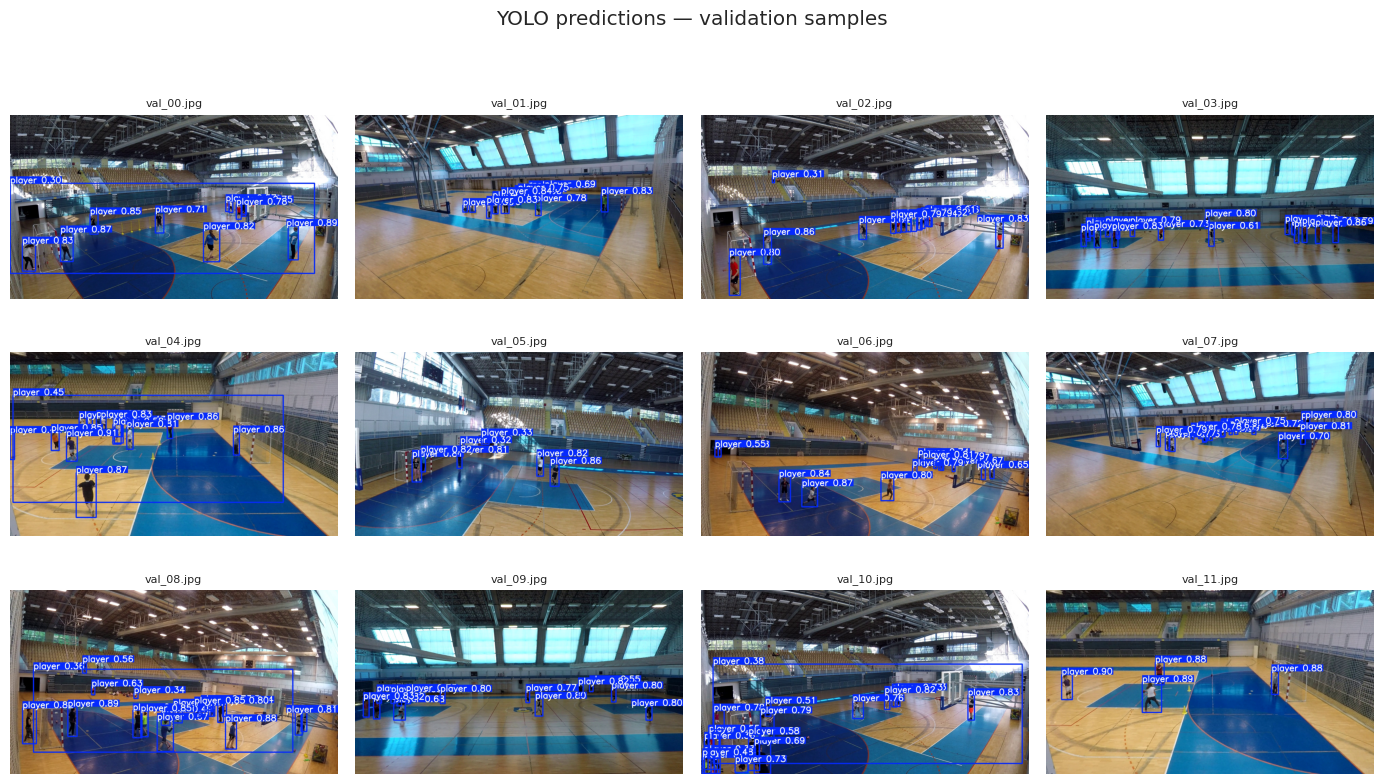

In [ ]:
fig, axes = plt.subplots(3,4, figsize=(14,8))

for ax, fn in zip(axes.flatten(), sorted(glob.glob(os.path.join(vis_dir, "val_*.jpg")))):

    img = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2RGB)
    ax.imshow(img); ax.axis('off'); ax.set_title(os.path.basename(fn), fontsize=8)

plt.suptitle("YOLO predictions — validation samples", y=1.02)
plt.tight_layout()
plt.show()

# **Homography & Live Stats**

In [ ]:
import colorsys

**Color Per Track ID**

In [ ]:
def color_for_id(tid: int):

    h = (tid * 0.1459) % 1.0
    r,g,b = colorsys.hsv_to_rgb(h, 0.85, 1.0)
    return (int(255*b), int(255*g), int(255*r))

In [ ]:
def draw_panel(img, lines, topleft=(10,10), width=420, alpha=0.55, header="Live Stats"):

    x0,y0 = topleft
    line_h = 24
    box_h = 10 + line_h*(len(lines)+1)
    panel = img.copy()
    cv2.rectangle(panel, (x0,y0), (x0+width, y0+box_h), (0,0,0), -1)
    out = cv2.addWeighted(panel, alpha, img, 1-alpha, 0)
    cv2.putText(out, header, (x0+10, y0+22), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,255), 2)

    for i, ln in enumerate(lines, start=1):

        cv2.putText(out, ln, (x0+10, y0+22+i*line_h), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)

    return out

In [ ]:
def draw_mini_court(img, tracks_xy_m, court_size=(40,20), position="bottom_center", offset=(0, 10), scale=6, trail=30):

    Himg, Wimg = img.shape[:2]
    Wm, Hm = court_size
    Wc, Hc = int(Wm*scale), int(Hm*scale)
    dx, dy = offset

    if position == "bottom_center":

        x1 = (Wimg - Wc)//2 + dx
        y1 = Himg - Hc - dy

    elif position == "top_right":

        x1 = Wimg - Wc - 10 + dx
        y1 = 10 + dy

    elif position == "top_left":

        x1 = 10 + dx
        y1 = 10 + dy

    else:

        x1 = 10 + dx
        y1 = 10 + dy

    x2, y2 = x1 + Wc, y1 + Hc

    court = img.copy()
    cv2.rectangle(court, (x1-4,y1-4), (x2+4,y2+4), (0,0,0), -1)
    cv2.rectangle(court, (x1,y1), (x2,y2), (40,40,40), -1)
    cv2.rectangle(court, (x1,y1), (x2,y2), (200,200,200), 2)

    for tid, pts in tracks_xy_m.items():

        if not pts:

            continue

        col = color_for_id(tid)

        if trail and len(pts) > 1:
            T = pts[-trail:]

            for i in range(1, len(T)):

                xm1, ym1 = T[i-1]; xm2, ym2 = T[i]
                px1 = int(x1 + (xm1/Wm)*Wc); py1 = int(y1 + (1-ym1/Hm)*Hc)
                px2 = int(x1 + (xm2/Wm)*Wc); py2 = int(y1 + (1-ym2/Hm)*Hc)
                cv2.line(court, (px1,py1), (px2,py2), col, 2)

        xm, ym = pts[-1]
        px = int(x1 + (xm/Wm)*Wc); py = int(y1 + (1-ym/Hm)*Hc)
        cv2.circle(court, (px,py), 4, col, -1)

    return court

**IoU Tracker**

In [ ]:
def iou_xyxy(a,b):

    x1,y1,x2,y2=a; X1,Y1,X2,Y2=b
    ix1,iy1=max(x1,X1),max(y1,Y1)
    ix2,iy2=min(x2,X2),min(y2,Y2)
    iw,ih=max(0.0,ix2-ix1),max(0.0,iy2-iy1)
    inter=iw*ih

    if inter<=0:
      return 0.0

    ua=max(0.0,x2-x1)*max(0.0,y2-y1)
    ub=max(0.0,X2-X1)*max(0.0,Y2-Y1)
    return inter/max(1e-9, ua+ub-inter)

In [ ]:
class IOUTracker:

    """Lightweight tracker to keep the notebook self-contained."""

    def __init__(self, iou_thr=0.3, max_age=8):
        self.iou_thr=iou_thr; self.max_age=max_age
        self.active={}
        self.next_id=1

    def update(self, dets):

        tr_ids=list(self.active.keys()); matched=set()

        # match existing tracks
        for tid in tr_ids:

            best_j, best_iou=-1,0.0

            for j,d in enumerate(dets):

                if j in matched:
                  continue

                i=iou_xyxy(self.active[tid]['box'], d[:4])

                if i>best_iou:

                  best_iou, best_j=i,j

            if best_j>=0 and best_iou>=self.iou_thr:

                self.active[tid]['box']=dets[best_j][:4]
                self.active[tid]['age']=0; matched.add(best_j)

            else:

                self.active[tid]['age']+=1

        # new tracks
        for j,d in enumerate(dets):

            if j not in matched:

                tid=self.next_id; self.next_id+=1
                self.active[tid]={'box':d[:4],'age':0}

        # flush old
        for tid in list(self.active.keys()):

            if self.active[tid]['age']>self.max_age:

                del self.active[tid]
        # output list
        return [(tid,self.active[tid]['box']) for tid in self.active]

**Homography Calibration**

In [ ]:
pixel_quad = np.float32([[50,680],[1230,680],[1230,50],[50,50]])
court_quad = np.float32([[0,20],[40,20],[40,0],[0,0]])
H_pix2m, _ = cv2.findHomography(pixel_quad, court_quad)

In [ ]:
def project_pixel_to_meters(xp, yp, H=H_pix2m):

    pt = np.array([[[xp, yp]]], dtype=np.float32)
    xm, ym = cv2.perspectiveTransform(pt, H)[0][0]

    return float(xm), float(ym)

In [ ]:
def footpoint_from_bbox(x1,y1,x2,y2):

    return (x1+x2)/2.0, y2

In [ ]:
def run_live_stats(video_path: str, model_path: str, out_mp4: str, conf_thr: float = 0.30, court_size=(40, 20), iou_thr: float = 0.35, max_age: int = 10, position: str = "bottom_center", trail: int = 30, ema_alpha: float = 0.25, speed_cap_mps: float = 12.0,):

    # YOLO model
    model = YOLO(model_path)

    # Video I/O
    cap = cv2.VideoCapture(video_path)
    assert cap.isOpened(), f"Cannot open {video_path}"
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS) or 25.0
    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    vw = cv2.VideoWriter(out_mp4, fourcc, fps, (W, H))

    # Lightweight tracker
    tracker = IOUTracker(iou_thr=iou_thr, max_age=max_age)

    last_xy_m = {}                           # id -> (xm, ym)
    ema_speed_mps = {}                       # id -> EMA speed (m/s)
    cum_dist_m = defaultdict(float)          # id -> total meters
    traj_xy_m = defaultdict(list)            # id -> [(xm, ym), ...]


    # Timing for FPS
    t0 = time.time()
    frames_done = 0

    pbar = tqdm(total=int(cap.get(cv2.CAP_PROP_FRAME_COUNT) or 0), desc="Live Stats (simple)")
    while True:

        ok, frame = cap.read()

        if not ok:

            break

        frames_done += 1

        # YOLO Inference
        res = model(frame, conf=conf_thr, device="cpu", verbose=False)[0]
        dets = []
        if res and res.boxes is not None and len(res.boxes) > 0:
            xyxy = res.boxes.xyxy.cpu().numpy()
            scr = res.boxes.conf.cpu().numpy()
            dets = np.c_[xyxy, scr]

        # IoU tracking
        tracks = tracker.update(dets)

        # Speed & Distance
        Wm, Hm = court_size
        speeds_now = []
        for tid, (x1, y1, x2, y2) in tracks:
            color = color_for_id(tid)

            # Draw bbox & ID
            cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), color, 2)
            cv2.putText(
                frame,
                f"ID{tid}",
                (int(x1), max(0, int(y1) - 6)),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.6,
                color,
                2,
                cv2.LINE_AA,
            )

            # Footpoint
            xp, yp = footpoint_from_bbox(x1, y1, x2, y2)
            xm, ym = project_pixel_to_meters(xp, yp, H_pix2m)

            xm = float(np.clip(xm, 0, Wm))
            ym = float(np.clip(ym, 0, Hm))

            # Distance / EMA speed
            v_mps = 0.0
            if tid in last_xy_m:

                dx, dy = xm - last_xy_m[tid][0], ym - last_xy_m[tid][1]
                dist = float(np.hypot(dx, dy))
                cum_dist_m[tid] += dist
                v_raw = min(dist * fps, speed_cap_mps)
                prev = ema_speed_mps.get(tid, v_raw)
                v_mps = ema_alpha * v_raw + (1 - ema_alpha) * prev
                ema_speed_mps[tid] = v_mps

            else:

                ema_speed_mps[tid] = 0.0

            last_xy_m[tid] = (xm, ym)
            traj_xy_m[tid].append((xm, ym))
            speeds_now.append(v_mps)

        # Metrics for the panel
        elapsed = time.time() - t0
        fps_proc = frames_done / max(1e-6, elapsed)
        rtf = fps_proc / fps
        n_active = len(tracks)
        avg_kmh = float(np.mean(speeds_now) * 3.6) if speeds_now else 0.0
        max_kmh = float(np.max(speeds_now) * 3.6) if speeds_now else 0.0

        top_id = max(cum_dist_m, key=cum_dist_m.get) if len(cum_dist_m) else None
        top_line = f"Top player ID by distance: {top_id}  |  Distance: {cum_dist_m[top_id]:.1f} m" if top_id is not None else "Top player ID by distance: -"

        lines = [
            f"Frames processed per second: {fps_proc:0.1f}  (Real-time factor: {rtf:0.2f}×)",
            f"Number of active players: {n_active}",
            f"Average speed: {avg_kmh:0.1f} km/h   |   Maximum speed: {max_kmh:0.1f} km/h",
            top_line,
        ]

        frame = draw_panel(frame, lines, topleft=(10, 10), width=560, header="Live Stats")
        frame = draw_mini_court(frame, traj_xy_m, court_size=court_size, position=position, offset=(0, 8), scale=6, trail=trail,)

        vw.write(frame)
        pbar.update(1)

    pbar.close()
    cap.release()
    vw.release()
    print("Saved video with Live Stats:", out_mp4)

In [ ]:
sample_csvs = sorted(glob.glob(os.path.join(detections_dir, actions[0], "*.csv")))
sample_video = csv_to_video_path(sample_csvs[0])

In [ ]:
best_pt = "/content/runs/detect/hb_cpu_phaseC/weights/best.pt"
out_demo = "/content/hmg_stats_demo.mp4"

In [ ]:
run_live_stats(
    video_path=sample_video,
    model_path=best_pt,
    out_mp4=out_demo,
    conf_thr=0.30,
    court_size=(40,20),
    iou_thr=0.35, max_age=10,
    position="bottom_center",
    trail=40, ema_alpha=0.25, speed_cap_mps=12.0
)

Live Stats (simple): 100%|██████████| 65/65 [00:04<00:00, 14.35it/s]

Saved video with Live Stats: /content/hmg_stats_demo.mp4


In [ ]:
display(Video(out_demo, embed=True, width=960))

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

# Ορισμός προορισμού στο Drive
import os, time, shutil
ts = time.strftime("%Y%m%d_%H%M%S")
drive_root = "/content/drive/MyDrive/ME2109"
os.makedirs(drive_root, exist_ok=True)
zip_out = f"{drive_root}/PartB_full_backup_{ts}.zip"

# Staging φάκελος (προσωρινό αντίγραφο πριν το zip)
staging = "/content/_backup_tmp"
if os.path.exists(staging):
    shutil.rmtree(staging)
os.makedirs(staging, exist_ok=True)

print("Drive dest:", zip_out)
print("Staging dir:", staging)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive dest: /content/drive/MyDrive/ME2109/PartB_full_backup_20250913_170234.zip
Staging dir: /content/_backup_tmp


In [ ]:
# Αντιγράφουμε σε staging με ΕΞΑΙΡΕΣΕΙΣ
!rsync -a --info=progress2 \
  --exclude="drive" \
  --exclude="uniri-hbd" \
  --exclude="handball_data/images" --exclude="handball_data/images/***" \
  --exclude="handball_data/labels" --exclude="handball_data/labels/***" \
  --exclude="sample_data" \
  --exclude="proc" --exclude="sys" --exclude="dev" --exclude="tmp" \
  /content/ "{staging}/"

# Γρήγορος έλεγχος
!du -sh "{staging}"
!find "{staging}" -maxdepth 2 -type d | sed "s|{staging}||" | sort

     79,021,884 100%  678.65MB/s    0:00:00 (xfr#146, to-chk=0/170)
76M	/content/_backup_tmp

/_backup_tmp
/_backup_tmp/_backup_tmp
/_backup_tmp/.config
/_backup_tmp/handball_data
/_backup_tmp/runs
/_backup_tmp/vis_preds
/.config
/.config/configurations
/.config/logs
/handball_data
/runs
/runs/detect
/vis_preds


In [ ]:

# Δημιουργία ZIP απευθείας στο Drive
!cd "{staging}" && zip -r "{zip_out}" . -x ".ipynb_checkpoints/*"

print("Saved ZIP:", zip_out)

# (Προαιρετικό) Καθάρισμα staging
import shutil
shutil.rmtree(staging, ignore_errors=True)
print("Cleaned staging.")

  adding: _backup_tmp/ (stored 0%)
  adding: _backup_tmp/_backup_tmp/ (stored 0%)
  adding: _backup_tmp/handball_data/ (stored 0%)
  adding: _backup_tmp/.config/ (stored 0%)
  adding: _backup_tmp/runs/ (stored 0%)
  adding: _backup_tmp/vis_preds/ (stored 0%)
  adding: handball_data/ (stored 0%)
  adding: handball_data/conf_calibration.json (deflated 70%)
  adding: handball_data/test.txt (deflated 92%)
  adding: handball_data/train.txt (deflated 93%)
  adding: handball_data/train_balanced.txt (deflated 93%)
  adding: handball_data/data.yaml (deflated 21%)
  adding: handball_data/val.txt (deflated 93%)
  adding: .config/ (stored 0%)
  adding: .config/active_config (stored 0%)
  adding: .config/config_sentinel (stored 0%)
  adding: .config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db (deflated 97%)
  adding: .config/.last_survey_prompt.yaml (stored 0%)
  adding: .config/.last_update_check.json (deflated 22%)
  adding: .config/default_configs.db (deflated 98%)
  adding: .